In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
conn.close()

Tables in the database:
sites
sqlite_sequence
alexa_ranks
policy_texts
policy_htmls
policy_reader_view_htmls
policy_snapshots


In [3]:
# Connect to the database
conn = sqlite3.connect('/app/Data/release_db.sqlite')

# Load policy_texts table (contains readability scores)
df_policy_texts = pd.read_sql_query("SELECT * FROM policy_texts", conn)

# Load sites table (contains website information)
df_sites = pd.read_sql_query("SELECT * FROM sites", conn)

# Load policy_snapshots table (connects policies to websites)
df_snapshots = pd.read_sql_query("SELECT * FROM policy_snapshots", conn)

# Close connection after loading data
conn.close()

In [4]:
print(df_policy_texts.head())

   id                                        policy_text  flesch_kincaid  \
0   1  DocuSign Express Privacy Policy (11/03)\n\nThe...       14.938384   
1   2  DocuSign Express™ Privacy Policy (11/03)\n\nOv...       13.762202   
2   3  The privacy practices of this statement apply ...       13.640407   
3   4  Overview \n\nThe privacy practices of this sta...       13.651666   
4   5  The privacy practices of this statement apply ...       13.660300   

        smog flesch_ease  length                                      sha1  \
0  18.351184   difficult   14137  37519a313f07f98fdbb51f13779ed7d6cb1b4468   
1  18.171460   difficult   14366  837c2e1fdab142cebb3cc008880309ee94a6ecbf   
2  18.062587   difficult   14363  9296f990b576e40dec5d0e54552918247192bd8f   
3  18.062587   difficult   14394  d4cceb6f40debdf45dfd5032f2b958692086ee23   
4  18.098966   difficult   14396  b92e7ce2eb30a2ad6e7cabfb6e0ed0af5ab84f4c   

               simhash  
0   862964595037544195  
1   863527407568723719  

In [5]:
print(df_sites.head())

   id             domain                categories
0   1     000domains.com  business;informationtech
1   2    000filehost.com  business;informationtech
2   3     000webhost.com  business;informationtech
3   4  000webhostapp.com  business;informationtech
4   5       001games.com                     games


In [6]:
print(df_snapshots.head())

   id  site_id                              homepage_snapshot_url  \
0   1    31160  https://web.archive.org/web/20031122123614id_/...   
1   2    31160  https://web.archive.org/web/20040924214154id_/...   
2   3    31160  https://web.archive.org/web/20061026200451id_/...   
3   4    31160  https://web.archive.org/web/20060402203037id_/...   
4   5    31160  https://web.archive.org/web/20040331103835id_/...   

                                 policy_snapshot_url  \
0  https://web.archive.org/web/20031207185149id_/...   
1  https://web.archive.org/web/20040816044548id_/...   
2  https://web.archive.org/web/20061219215634id_/...   
3  https://web.archive.org/web/20060616002221id_/...   
4  https://web.archive.org/web/20040610023406id_/...   

                                  policy_url  \
0         docusign.com/eDocuSign/privacy.asp   
1                   docusign.com/privacy.asp   
2  docusign.com/resources/privacy_policy.php   
3  docusign.com/resources/privacy_policy.php   
4       

In [7]:
df_merged = pd.merge(df_policy_texts, df_snapshots, left_on='id', right_on='policy_text_id')
df_merged.head()

,id_x,policy_text,flesch_kincaid,smog,flesch_ease,length,sha1,simhash,id_y,site_id,...,policy_html_id,policy_reader_view_html_id,file_type,policy_title,link_text,pdf_filename,classifier_probability,analysis_subcorpus,parked_domain,cross_domain_homepage_redir
0,1,DocuSign Express Privacy Policy (11/03)\n\nThe...,14.938384,18.351184,difficult,14137,37519a313f07f98fdbb51f13779ed7d6cb1b4468,862964595037544195,1,31160,...,1,1,html,Privacy Policy,Privacy policy,,0.966039,1,0,0
1,2,DocuSign Express™ Privacy Policy (11/03)\n\nOv...,13.762202,18.171460,difficult,14366,837c2e1fdab142cebb3cc008880309ee94a6ecbf,863527407568723719,2,31160,...,2,2,html,"DocuSign, Inc. - Privacy Policy",Privacy Policy,,0.966039,1,0,0
2,2,DocuSign Express™ Privacy Policy (11/03)\n\nOv...,13.762202,18.171460,difficult,14366,837c2e1fdab142cebb3cc008880309ee94a6ecbf,863527407568723719,5,31160,...,5,2,html,"DocuSign, Inc. - Privacy Policy",Privacy Policy,,0.966039,1,0,0
3,3,The privacy practices of this statement apply ...,13.640407,18.062587,difficult,14363,9296f990b576e40dec5d0e54552918247192bd8f,4321728971435908871,3,31160,...,3,3,html,DocuSign.com,Privacy Policy,,0.966039,1,0,0
4,3,The privacy practices of this statement apply ...,13.640407,18.062587,difficult,14363,9296f990b576e40dec5d0e54552918247192bd8f,4321728971435908871,4,31160,...,4,3,html,DocuSign.com,Privacy Policy,,0.966039,1,0,0


In [8]:
df_full = pd.merge(df_merged, df_sites, left_on='site_id', right_on='id')
df_full.head()

,id_x,policy_text,flesch_kincaid,smog,flesch_ease,length,sha1,simhash,id_y,site_id,...,policy_title,link_text,pdf_filename,classifier_probability,analysis_subcorpus,parked_domain,cross_domain_homepage_redir,id,domain,categories
0,1,DocuSign Express Privacy Policy (11/03)\n\nThe...,14.938384,18.351184,difficult,14137,37519a313f07f98fdbb51f13779ed7d6cb1b4468,862964595037544195,1,31160,...,Privacy Policy,Privacy policy,,0.966039,1,0,0,31160,docusign.com,business;informationtech
1,2,DocuSign Express™ Privacy Policy (11/03)\n\nOv...,13.762202,18.171460,difficult,14366,837c2e1fdab142cebb3cc008880309ee94a6ecbf,863527407568723719,2,31160,...,"DocuSign, Inc. - Privacy Policy",Privacy Policy,,0.966039,1,0,0,31160,docusign.com,business;informationtech
2,2,DocuSign Express™ Privacy Policy (11/03)\n\nOv...,13.762202,18.171460,difficult,14366,837c2e1fdab142cebb3cc008880309ee94a6ecbf,863527407568723719,5,31160,...,"DocuSign, Inc. - Privacy Policy",Privacy Policy,,0.966039,1,0,0,31160,docusign.com,business;informationtech
3,3,The privacy practices of this statement apply ...,13.640407,18.062587,difficult,14363,9296f990b576e40dec5d0e54552918247192bd8f,4321728971435908871,3,31160,...,DocuSign.com,Privacy Policy,,0.966039,1,0,0,31160,docusign.com,business;informationtech
4,3,The privacy practices of this statement apply ...,13.640407,18.062587,difficult,14363,9296f990b576e40dec5d0e54552918247192bd8f,4321728971435908871,4,31160,...,DocuSign.com,Privacy Policy,,0.966039,1,0,0,31160,docusign.com,business;informationtech


In [9]:
# Print all unique categories from the 'categories' column
unique_categories = df_full['categories'].unique()
unique_categories

array(['business;informationtech', 'business;education;informationtech',
       'searchenginesandportals', 'uncategorized', '', 'parked',
       'informationtech', 'contentserver;newsandmedia', 'advertising',
       'business', 'blogsandpersonal', 'business;education',
       'business;entertainment', 'contentserver;informationtech',
       'personals', 'education;informationtech',
       'business;education;entertainment',
       'blogsandpersonal;business;informationtech', 'streamingmedia',
       'education', 'education;entertainment',
       'business;searchenginesandportals', 'contentserver',
       'entertainment', 'shopping', 'drugs;shopping',
       'business;entertainment;informationtech', 'business;shopping',
       'advertising;business', 'entertainment;streamingmedia',
       'adult;informationtech', 'blogsandpersonal;business;entertainment',
       'business;economyandfinance',
       'education;entertainment;streamingmedia', 'adult;entertainment',
       'business;educati

In [10]:
# Split semicolon-separated categories into individual rows for better analysis
df_categories = df_full['categories'].str.split(';', expand=True)

# Print the first few rows to see how the data looks after splitting
print(df_categories.head())

          0                1     2     3
0  business  informationtech  None  None
1  business  informationtech  None  None
2  business  informationtech  None  None
3  business  informationtech  None  None
4  business  informationtech  None  None


In [11]:
# Split semicolon-separated categories into individual columns
df_categories = df_full['categories'].str.split(';', expand=True)

# Check if any of the columns contain 'advertising'
df_full['is_advertising'] = df_categories.apply(lambda col: col.str.contains('advertising', case=False, na=False)).any(axis=1).astype(int)

# Check if the binary column is correctly created
print(df_full[['domain', 'categories', 'is_advertising']].head())

         domain                categories  is_advertising
0  docusign.com  business;informationtech               0
1  docusign.com  business;informationtech               0
2  docusign.com  business;informationtech               0
3  docusign.com  business;informationtech               0
4  docusign.com  business;informationtech               0


In [12]:
df_full.shape

(1071487, 31)

/tmp/ipykernel_4130/717572655.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_full[['flesch_kincaid', 'smog', 'flesch_ease', 'is_advertising']].corr()


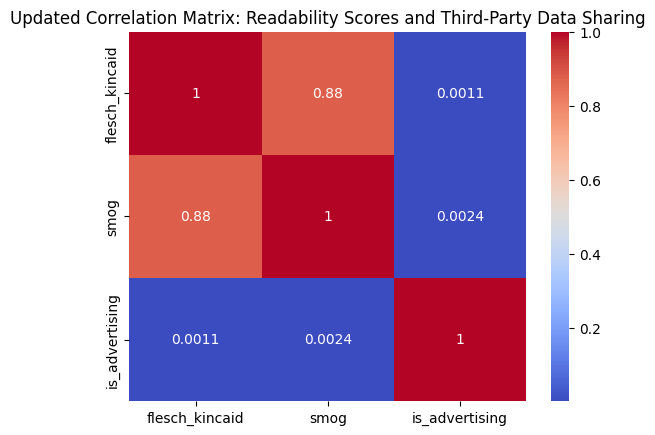

In [13]:
# Re-run correlation analysis with updated 'is_advertising' column
correlation_matrix = df_full[['flesch_kincaid', 'smog', 'flesch_ease', 'is_advertising']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Updated Correlation Matrix: Readability Scores and Third-Party Data Sharing')
plt.show()

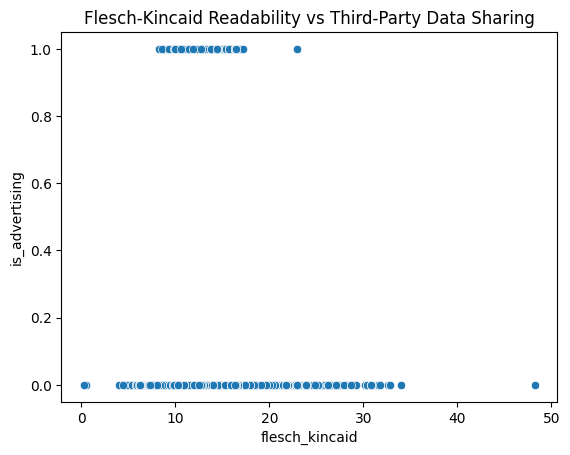

In [14]:
# Plot Flesch-Kincaid score vs third-party data sharing indicator (is_advertising)
sns.scatterplot(x='flesch_kincaid', y='is_advertising', data=df_full)
plt.title('Flesch-Kincaid Readability vs Third-Party Data Sharing')
plt.show()

Clustering at is_advertising = 0:
* Most data points are clustered at is_advertising = 0 => large portion of the websites in the dataset are not classified as advertising-related.
* No clear trend between Flesch-Kincaid readability scores and being an advertising website.

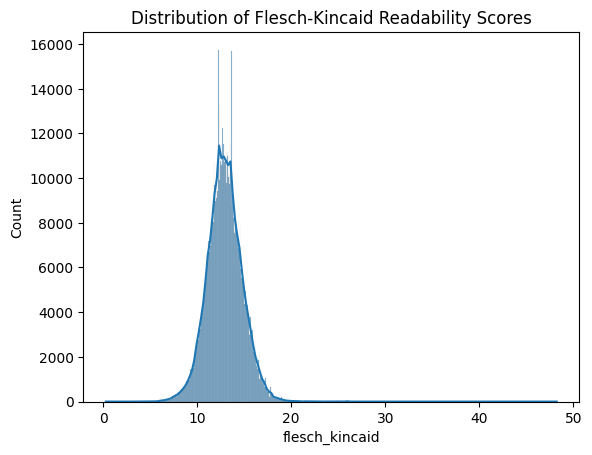

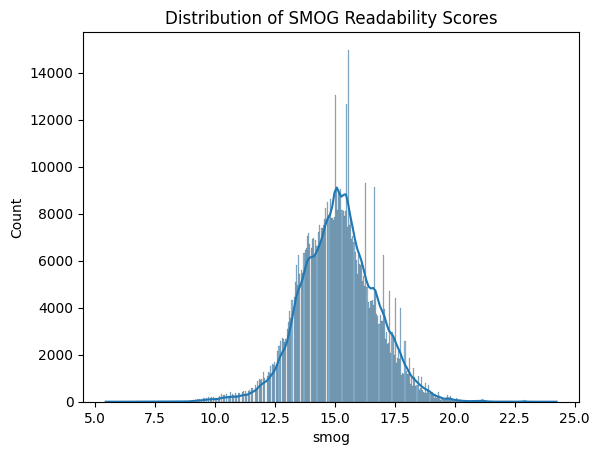

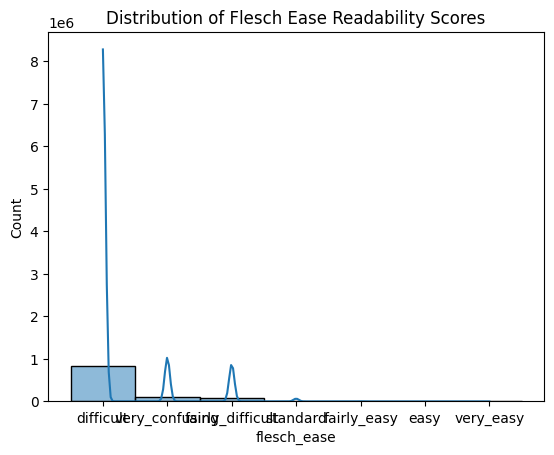

In [15]:
# Plot distributions of readability scores
sns.histplot(df_full['flesch_kincaid'], kde=True)
plt.title('Distribution of Flesch-Kincaid Readability Scores')
plt.show()

sns.histplot(df_full['smog'], kde=True)
plt.title('Distribution of SMOG Readability Scores')
plt.show()

sns.histplot(df_full['flesch_ease'], kde=True)
plt.title('Distribution of Flesch Ease Readability Scores')
plt.show()


In [ ]:
df_track = pd.read_csv('/app/Data/tracking-graph.tsv.gz', sep='\t', compression='gzip', header=None, names=['domain_id', 'tracking_domain_id'])

In [ ]:
df_index = pd.read_csv('/app/Data/pld-index.tsv.gz', sep='\t', names=['domain', 'domain_id'])

In [ ]:
df = pd.merge(df_track, df_index, on='domain_id', how='inner')
df.head()